In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, ttest_ind
import random
from potosnail import Stats

df = pd.read_csv(r'C:\Users\aacjp\Sales-Scientist\datasets\check6.csv').drop(['Unnamed: 0'], axis='columns')
df.head()

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
0,clickfunnels.com,https://funnelscripts.com/funnelscripts-webclass,1,marketing,software,word of mouth,70000,5000000,9000000,0.219405,...,1270,0.353865,30303,8.958190e+06,0.038501,127.974142,3930000,0.436667,21736.00000,3006.752577
1,kinobody.com,https://go.kinobody.com/quiz/,1,fitness,info / coaching,word of mouth,210000,20000,630000,0.067753,...,88504,0.121291,9130,5.145120e+05,138.980807,2.450057,400000,0.634921,105833.00000,9.700074
2,FrankKern.com,https://frankkernbook.com/optin24883998?utm_so...,1,entrepreneurship,info,NaN,54437,18666,583310,0.000000,...,120191,0.174400,194,7.174713e+04,280.000000,1.317985,510207,87.470000,2198.00000,996.810407
3,ImpactTheory.Com,NaN,1,self-development,media,NaN,126095,8000,250000,0.288006,...,211062,0.140200,25773,3.057500e+04,5.000000,0.242476,115905,46.360000,10787.69697,297.007329
4,digitalmillionairesecrets.com,https://highticketselling.com/,1,entrepreneurship,info,NaN,139711,53333,1666667,0.345833,...,5225501,0.656100,1672,1.380500e+06,84.000000,9.881112,1473623,88.420000,113.00000,1996.005988


# EDA Questions
1. does having a high lpc (landing page complexity) have a negative relationship with roas (return on adspend)? What about for trigger words number of words, and number of links per landing page?
2. What range accuratley represents the closing rate? In more technical terms, what is the 95% confidence interval?
3. What range accuratley represents the revenue of customers? In more technical terms, what is the 95% confidence interval? What about 68%?
4. Test for signifigant difference in adspend based on the lead's business models and whether or not they closed. AKA Chai-Squared Test.
5. Can we provide meaningful insights with bootstrap sampling?
6. how does twitter sentiment map onto the change in the number of monthly visits?
7. what is the revenue of the leads with the highest ranked websites? run bootsrap sampling to see if there's a signifigant difference.
8.

In [2]:
x = np.array(df['lpc'])
y = np.array(df['roas'])

lpc and roas

In [3]:
np.corrcoef(x, y=y)

array([[1.        , 0.03356925],
       [0.03356925, 1.        ]])

Number of words in landing page and roas

In [4]:
x = np.array(df['words'])
y = np.array(df['roas'])
np.corrcoef(x, y=y)

array([[ 1.        , -0.09007687],
       [-0.09007687,  1.        ]])

Number of trigger words in landing page and roas

In [5]:
x = np.array(df['triggers'])
y = np.array(df['roas'])
np.corrcoef(x, y=y)

array([[ 1.        , -0.02151948],
       [-0.02151948,  1.        ]])

In [6]:
x = np.array(df['links'])
y = np.array(df['roas'])
np.corrcoef(x, y=y)

array([[1.        , 0.02006478],
       [0.02006478, 1.        ]])

## findings

number of words and number of trigger words (trigger a call to action) have a slight negative correlation, leading to slightly lower roas. However number of links in the landing page has a slight positive correlation with roas, not what was excpected, however at 2% correlation this is negligible.

Text(0.5, 1.0, 'How many words is too many?')

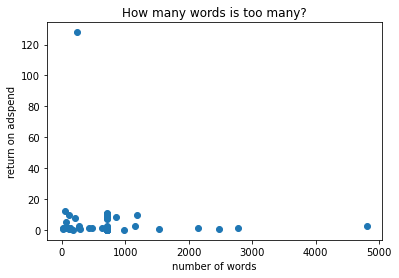

In [7]:
plt.scatter(df['words'], df['roas'])
plt.xlabel('number of words')
plt.ylabel('return on adspend')
plt.title('How many words is too many?')

Text(0.5, 1.0, 'How many trigger words is too many?')

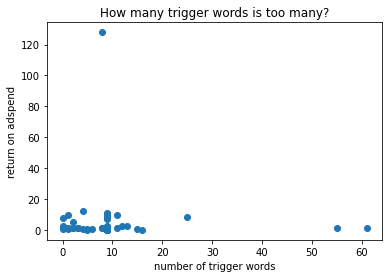

In [8]:
plt.scatter(df['triggers'], df['roas'])
plt.xlabel('number of trigger words')
plt.ylabel('return on adspend')
plt.title('How many trigger words is too many?')

Text(0.5, 1.0, 'Do links boost roas?')

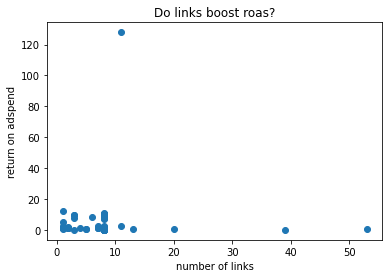

In [9]:
plt.scatter(df['links'], df['roas'])
plt.xlabel('number of links')
plt.ylabel('return on adspend')
plt.title('Do links boost roas?')

In [10]:
under_700 = df.loc[df['words']<700]
over_700 = df.loc[df['words']>=700]

In [11]:
p_thresh = 0.05
ttest_ind(under_700['roas'], over_700['roas']), p_thresh

(Ttest_indResult(statistic=0.9907182819962105, pvalue=0.3260102942525549),
 0.05)

we failed to reject the null hypothesis, but we'll do some more digging

In [12]:
np.mean(under_700['roas']), np.mean(over_700['roas'])

(8.239649538863633, 3.7932887841891887)

In [13]:
np.median(under_700['roas']), np.median(over_700['roas'])

(1.2465181955, 1.274138918)

In [14]:
def bootstrap(x):
    samples = []
    for i in range(len(x)):
        sample = random.sample(x, 1)[0]
        samples.append(sample)
    return samples

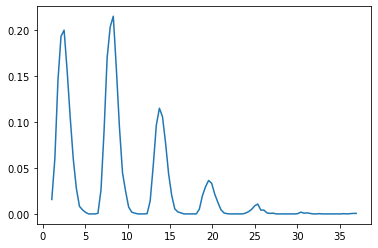

In [15]:
from potosnail import Stats
bootstrap(list(under_700['roas']))

xbars = []
for i in range(10000):
    xbars.append(np.mean(bootstrap(list(under_700['roas']))))
Stats().PDF(xbars)

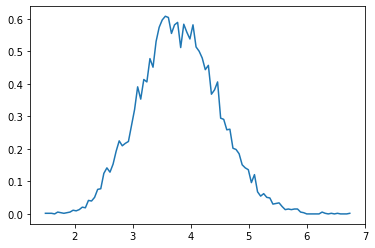

In [16]:
bootstrap(list(over_700['roas']))

xbars = []
for i in range(10000):
    xbars.append(np.mean(bootstrap(list(over_700['roas']))))
Stats().PDF(xbars)

In [17]:
df.loc[df['roas']==max(df['roas'])]

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
0,clickfunnels.com,https://funnelscripts.com/funnelscripts-webclass,1,marketing,software,word of mouth,70000,5000000,9000000,0.219405,...,1270,0.353865,30303,8958189.977,0.038501,127.974142,3930000,0.436667,21736.0,3006.752577


## Actionable insight
if a lead's landing page has more than 700 words it is an indicator that their roas is low and there's a leak in their adspend, meaning we could save them a higher percentage of adspend. As a result we can prioritize these leads, reps should ask these prospects questions that reveal if the prospect is unsatisfied with their current roas. Additionally reps can use 'fixing leaks in adspend' as a selling point. We should also note that leads with under 700 word landing pages have more variance and are sparked by outliers with very high roas.

in a nutshell...
* prioritize leads with 700+ words in their landing page
* leverage the leaky adspend pain point for these prospects
* offer advice on how to clean up the landing page to provide value upfront

# 2. What range accuratley represents the closing rate? In more technical terms, what is the 95% confidence interval?

In [18]:
import random 

def GetCI(pop, n, ss=30, t=2):
    x = []
    for i in range(n):
        sample = random.sample(pop, ss)
        x.append(sum(sample)/len(sample))
    xbar = np.mean(x)
    sigma = np.std(x)
    minimum = xbar - (sigma*t)
    maximum = xbar + (sigma*t)
    return (minimum, maximum)

In [19]:
GetCI(list(df['customer']), 1000)

(0.3846287166630226, 0.6339712833369773)

Based on the data we are 95% confident that our closing rate is between 37% and 64%. Do keep in mind that this dataset does not accuratley represent the customer base and the closing rate is likley a good bit lower.

# 3. What range accuratley represents the revenue of customers? In more technical terms, what is the 95% confidence interval? What about 68%?

In [20]:
customers = df.loc[df['customer']==1]
GetCI(list(customers['revenue']), 10, ss=16)

(-184208.04299925966, 6108735.83049926)

##### We have 95% confidence that our customers generate less than 5.85 million dollars per month on average

In [21]:
GetCI(list(customers['revenue']), 10, ss=16, t=1)

(1123920.404276058, 4452811.245723942)

We have 68% confidence that our customers generate 104 thousand to 4.6 million dollars per month on average

In [22]:
customers.loc[customers['revenue']<=104000]

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
11,SmarterNutrition.com,https://try.smarternutrition.com/collagen/,1,fitness,ecommerce,NaN,45035,27475,78500,0.000000,...,632196,0.210243,1963,32279.0,23.0,0.716754,5990,7.63,2506.00000,799.359712
15,leadgenblueprint.ryanwegner.com,https://www.highticketcoaches.co/limited-time-...,1,entrepreneurship,info,NaN,14289,1574,49203,0.103704,...,5225501,0.210243,99,18510.0,144.0,1.295402,33334,67.76,140.00000,1994.299145
19,Current9.com,https://go.current9.com/try-current948920879,1,entrepreneurship,info,NaN,22767,2509,78408,0.103704,...,5225501,0.210243,99,29261.0,230.0,1.285237,53132,67.39,451.00000,6000.000000
21,prestigepromedia.com,NaN,1,marketing,consulting,NaN,31200,0,78000,0.103704,...,2515826,0.210243,13,321360.0,0.0,10.300000,78000,100.00,10787.69697,295.089943
25,heybrain.com,NaN,1,technology,info,NaN,15000,48,1485,-0.073704,...,5225501,0.210243,99,1485.0,152.0,0.099000,-13563,-9.13,10787.69697,1250.000000


In [23]:
customers.loc[customers['revenue']>=4600000]

,name,landingPage,customer,domain,model,source,adspend,hardcosts,revenue,avg_polarity,...,global,percentPaid,sales,adRevenue,cac,roas,profit,profitMargin,lpc,averageOrderValue
0,clickfunnels.com,https://funnelscripts.com/funnelscripts-webclass,1,marketing,software,word of mouth,70000,5000000,9000000,0.219405,...,1270,0.353865,30303,8958189.977,0.038501,127.974142,3930000,0.436667,21736.00000,3006.752577
16,groovelife.com,https://groovelife.com/collections/new-womens-...,1,apparel,ecommerce,NaN,2332049,3237500,9250000,0.000000,...,93743,0.638900,205556,5595325.000,11.000000,2.399317,3680451,39.790000,4820.00000,2976.190476
24,gatestonebpo.com,NaN,1,finance,consulting,NaN,2558334,0,51166667,0.103704,...,2480630,0.210243,8000,6140000.000,320.000000,2.399999,45026667,88.000000,10787.69697,1997.000000


<AxesSubplot:xlabel='revenue', ylabel='Density'>

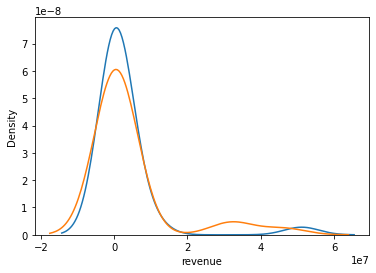

In [27]:
sns.kdeplot(x=customers['revenue'])
sns.kdeplot(x=df.loc[df['customer']==0]['revenue'])

## takeaway...

our leads that convert are most likley to be between 1 million and 50 million in annual revenue.

# 4. Test for signifigant difference in adspend based on the lead's business models and whether or not they closed.

Test 1: do customers and non-customers spend the same on ads?

H0: customers and non-customers spend the same on ads.

H1: customers and non-customers do not spend the same on ads.

p-threshold: 0.05

In [25]:
customers = list(df.loc[df['customer']==1]['adspend'])[:-1]
non_customers = list(df.loc[df['customer']==0]['adspend'])
print(chisquare(customers, f_exp=non_customers))
print(np.mean(customers), np.mean(non_customers))

Power_divergenceResult(statistic=445917035.13939524, pvalue=0.0)
275443.1379310345 668976.1034482758


In [26]:
customers = list(df.loc[df['customer']==1]['revenue'])[:-1]
non_customers = list(df.loc[df['customer']==0]['revenue'])
print(chisquare(customers, f_exp=non_customers))
print(np.mean(customers), np.mean(non_customers))

Power_divergenceResult(statistic=8289055242.980027, pvalue=0.0)
2825405.103448276 4267292.310344827


We reject the null hypothesis that customers and non-customers spend the same on ads and consider it reasonable to believe that customers spend signifigantly less on ads. This is likley because revenue is signifigantly lower

<AxesSubplot:>

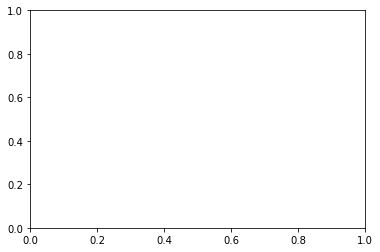

In [25]:
sns.kdeplot()